#0. Dependências

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse, r2_score

#1.0 Carregando os dados

In [0]:
df = pd.read_csv('cartola_2014.csv')
df.head()

,atleta_id,rodada,clube_id,participou,posicao_id,jogos_num,pontos_num,media_num,preco_num,variacao_num,partida_id,mando,titular,substituido,tempo_jogado,nota,FS,PE,A,FT,FD,FF,G,I,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS
0,37958,1,262.0,1,1.0,1,8.0,8.0,19.69,1.69,179872.0,1,1.0,0,1.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,68873,1,262.0,0,1.0,0,0.0,0.0,4.00,0.00,179872.0,1,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,37701,1,262.0,1,2.0,1,0.4,0.4,16.97,-5.03,179872.0,1,1.0,0,1.0,6.0,0,7,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
3,71602,1,262.0,0,2.0,0,0.0,0.0,3.00,0.00,179872.0,1,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,37684,1,262.0,1,3.0,1,9.1,9.1,10.68,5.68,179872.0,1,1.0,0,1.0,6.0,2,1,0,0,1,0,0,1,0,2,1,0,0,0,1,0,0,0


#1.1 Limpeza dos dados

Para criar amostras corretas e relevantes para o preditor. Analisando os dados previamente, alguns problemas foram detectados:

* **Jogadores com participou = 0**
* **Jogadores com clube_id = 0**
* **Jogadores com jogos_num = 0**

Para manter a consistência dos dados, nenhuma coluna será adicionada, alterada ou removida. Entretanto, os dados podem ser removidos ou corrigidos quando necessário.



In [0]:
print("Dimensões originais dos dados: ", df.shape)

Dimensões originais dos dados:  (29184, 34)


In [0]:
# Removendo jogadores que jogos_num == 0
df_clean = df[df['jogos_num'] > 0]
print("Quantidade de linhas após eliminação de jogadores que sua participação == 0: ", df_clean.shape[0])

# Removendo jogadores com club_id == 0
df_clean = df_clean[df_clean['clube_id'] > 0]
print("Quantidade de linhas após eliminação de club_id == 0: ", df_clean.shape[0])

df_nao_participou = df_clean[df_clean['participou'] == 0] # Jogadores que não participaram

# Removendo jogadores que participou == 0
df_clean = df_clean[df_clean['participou'] == 1]
print("Quantidade de linhas após eliminação de jogadores que sua participação == 0: ", df_clean.shape[0])

df_clean.fillna(value=0, inplace=True)
df_clean.head()

Quantidade de linhas após eliminação de jogadores que sua participação == 0:  20045
Quantidade de linhas após eliminação de club_id == 0:  14062
Quantidade de linhas após eliminação de jogadores que sua participação == 0:  10576


,atleta_id,rodada,clube_id,participou,posicao_id,jogos_num,pontos_num,media_num,preco_num,variacao_num,partida_id,mando,titular,substituido,tempo_jogado,nota,FS,PE,A,FT,FD,FF,G,I,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS
0,37958,1,262.0,1,1.0,1,8.0,8.0,19.69,1.69,179872.0,1,1.0,0,1.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
2,37701,1,262.0,1,2.0,1,0.4,0.4,16.97,-5.03,179872.0,1,1.0,0,1.0,6.0,0,7,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
4,37684,1,262.0,1,3.0,1,9.1,9.1,10.68,5.68,179872.0,1,1.0,0,1.0,6.0,2,1,0,0,1,0,0,1,0,2,1,0,0,0,1,0,0,0
5,68958,1,262.0,1,3.0,1,6.3,6.3,15.38,1.38,179872.0,1,1.0,0,1.0,6.0,1,1,0,0,0,1,0,0,0,2,2,0,1,0,1,0,0,0
7,38311,1,262.0,1,4.0,1,3.0,3.0,7.57,0.57,179872.0,1,1.0,0,1.0,6.0,2,3,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0


In [0]:
print("Dimensões após a limpeza de dados:",df_clean.shape)

Dimensões após a limpeza de dados: (10576, 34)


#1.2 Correlação

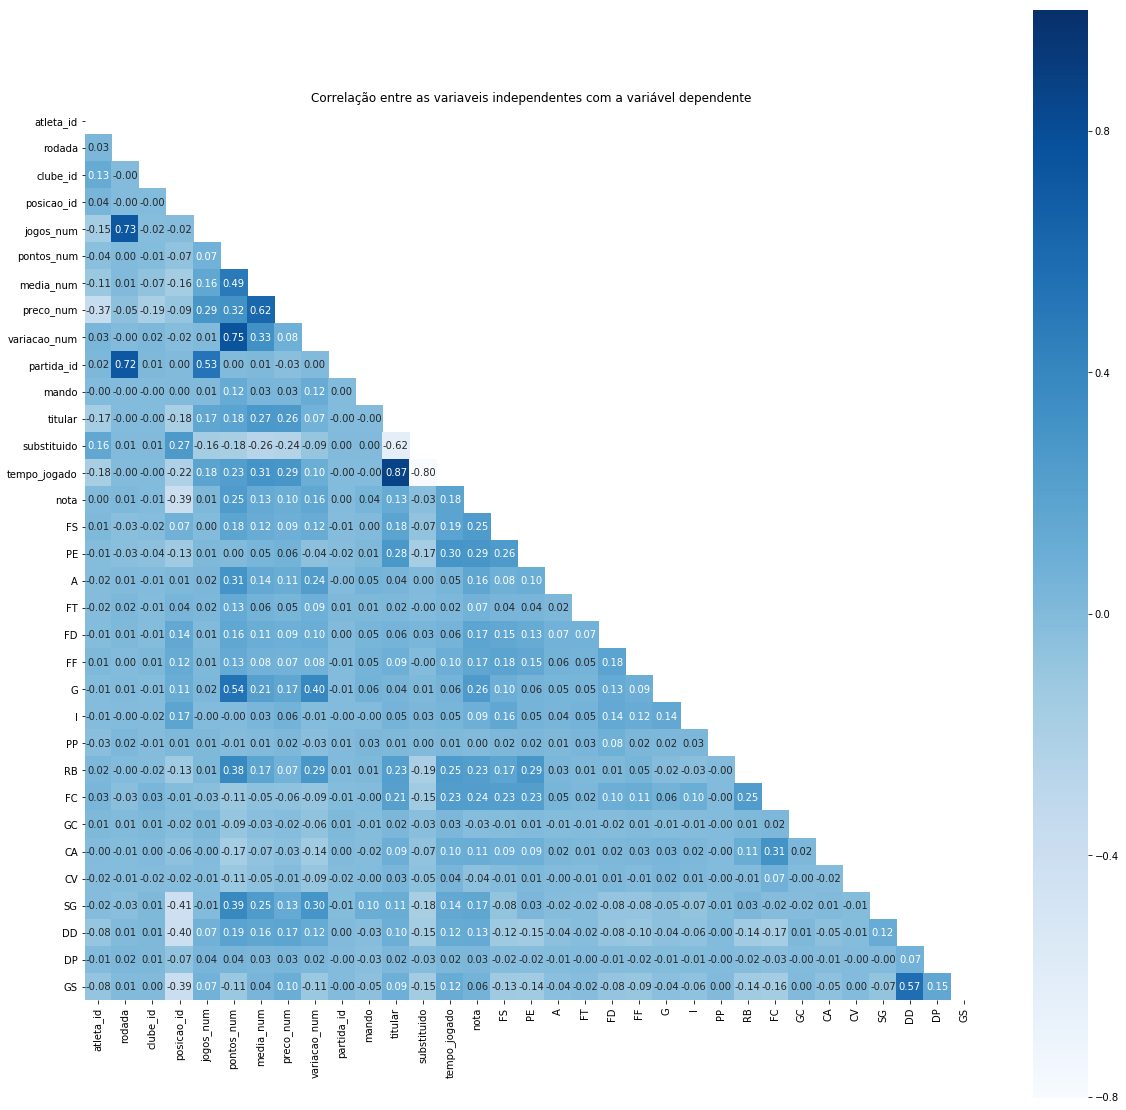

In [0]:
correlation = df_clean.drop('participou', axis=1).corr(method='pearson')


mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots()
ax.set_title("Correlação entre as variaveis independentes com a variável dependente")
ax.figure.set_size_inches(20, 20)
sns.heatmap(correlation, ax=ax, annot=True, mask=mask, fmt='.2f', cbar=True, square=True, cmap=plt.cm.Blues, center=0.1)

#1.3 Distribuição dos dados

In [0]:
df_clean.describe()

,atleta_id,rodada,clube_id,participou,posicao_id,jogos_num,pontos_num,media_num,preco_num,variacao_num,partida_id,mando,titular,substituido,tempo_jogado,nota,FS,PE,A,FT,FD,FF,G,I,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS
count,10576.000000,10576.000000,10576.000000,10576.0,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000
mean,62287.753688,18.544062,282.827629,1.0,3.712368,11.144762,2.695980,2.712817,8.179620,-0.000099,180058.553517,0.500567,0.805314,0.388238,0.805286,5.302572,1.044440,2.101078,0.053139,0.015507,0.217379,0.311649,0.072617,0.134739,0.001702,0.858075,1.096256,0.002175,0.146180,0.006051,0.119989,0.094554,0.001135,0.074792
std,17108.133697,10.353102,14.931765,0.0,1.330459,7.939496,4.064172,2.013034,5.042309,1.223742,111.111904,0.500023,0.395978,0.487372,0.305078,2.000184,1.301721,2.083799,0.239806,0.125084,0.501275,0.620593,0.285212,0.448269,0.041222,1.202046,1.281769,0.046586,0.353838,0.077559,0.325254,0.478319,0.033667,0.392343
min,36443.000000,1.000000,262.000000,1.0,1.000000,1.000000,-12.000000,-12.000000,0.760000,-7.240000,179872.000000,0.000000,0.000000,0.000000,-0.044444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,42234.000000,10.000000,266.000000,1.0,3.000000,4.000000,0.000000,1.400000,4.140000,-0.630000,179963.000000,0.000000,1.000000,0.000000,0.677778,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68817.000000,19.000000,284.000000,1.0,4.000000,10.000000,1.700000,2.660000,7.310000,-0.060000,180056.000000,1.000000,1.000000,0.000000,1.000000,6.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,77895.000000,28.000000,290.000000,1.0,5.000000,16.000000,4.800000,3.820000,11.410000,0.560000,180146.000000,1.000000,1.000000,1.000000,1.000000,6.500000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,89898.000000,36.000000,316.000000,1.0,6.000000,36.000000,31.900000,22.100000,29.610000,14.800000,180254.000000,1.000000,1.000000,1.000000,1.044444,9.500000,10.000000,17.000000,3.000000,2.000000,4.000000,7.000000,3.000000,7.000000,1.000000,9.000000,10.000000,1.000000,2.000000,1.000000,1.000000,7.000000,1.000000,6.000000


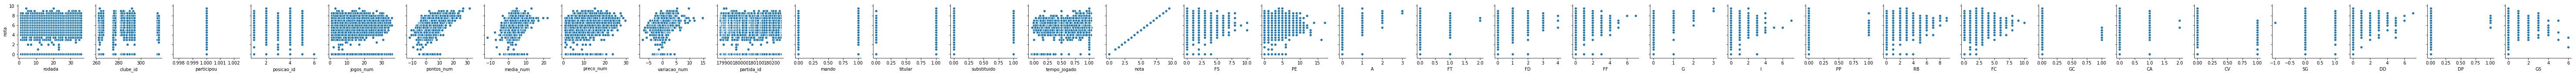

In [0]:
sns.pairplot(df_clean, x_vars=df.columns[1:], y_vars='nota')
plt.show()

#2.0 Usando todas as variáveis disponíveis, tune (usando validação cruzada):

##Treino E Teste

In [0]:
treino = df_clean
treino.fillna(value=0, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae86949828>,
      dtype=object)

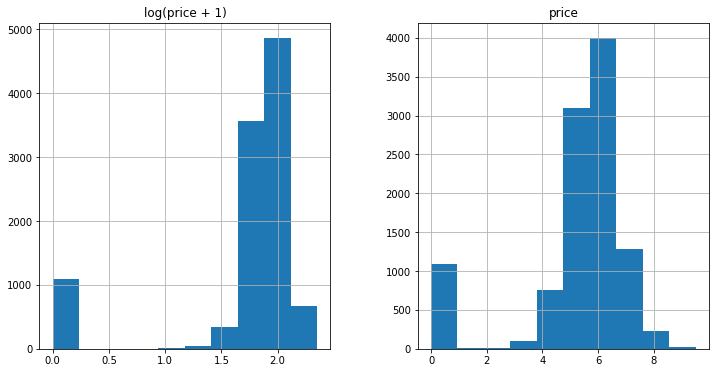

In [0]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":treino["nota"], "log(price + 1)":np.log1p(treino["nota"])})
prices.hist()

In [0]:
#log transform the target:
#treino["nota"] = np.log1p(treino["nota"])

#treino = pd.get_dummies(treino)
#treino = treino.fillna(treino.mean())
#treino.replace([np.inf, -np.inf], np.nan)



In [0]:
x_treino, y_treino = treino.drop('nota', axis=1), treino['nota']
#x_id = x.drop('atleta_id', axis=1)
#x_treino, x_teste, y_treino, y_teste = train_test_split(x_id, y,test_size = 0.33 )


#2.1 Modelo Ridge 

In [0]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, x_treino, y_treino, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [0]:
model_ridge = Ridge()

In [0]:
alphas = [-0.1,-1,0.05, 0.01, 0.3, 1, 3, 5, 10, 20, 30, 50, 80]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

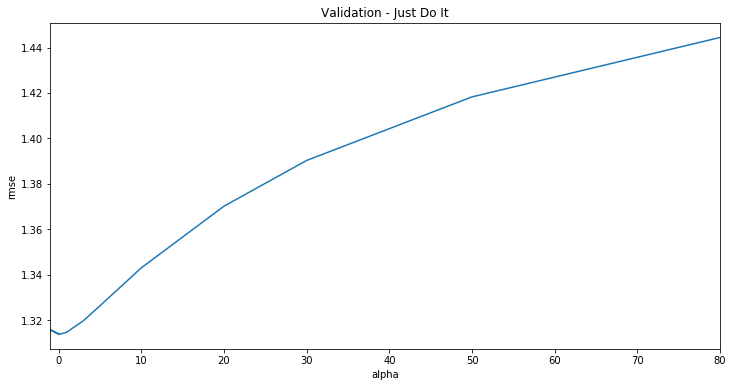

In [0]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")


In [0]:
ridge_penalty =cv_ridge.argmin()
best_rmse = cv_ridge.min()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


In [0]:
print (ridge_penalty, best_rmse)

0.05 1.3138614216522928


#2.2 Modelo Lasso

Text(0, 0.5, 'rmse')

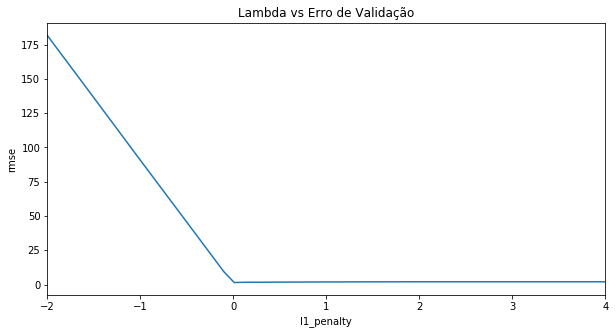

In [0]:
alphas = [-2,-1.5,-1,-0.5,-0.1,0.01,0.1,0.5,1.5,2,4]

cv_lasso = [rmse_cv(Lasso(alpha=alpha)).mean() for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index=alphas)

plt.figure(figsize=(10, 5))
cv_lasso.plot(title="Lambda vs Erro de Validação")
plt.xlabel("l1_penalty")
plt.ylabel("rmse")


In [0]:
lasso_penalty=cv_lasso.argmin()
best_rmse = cv_lasso.min()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


In [0]:
print (lasso_penalty, best_rmse)

0.01 1.443834761422448


#2.3 Modelo KNN

Text(0, 0.5, 'rmse')

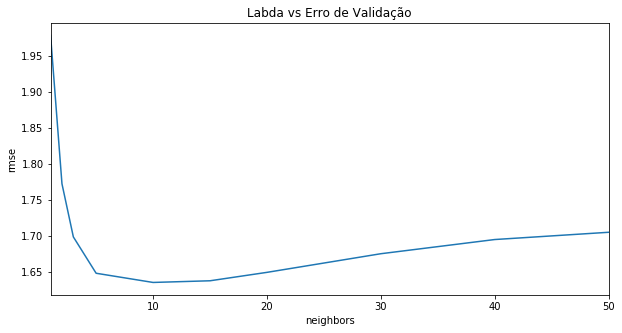

In [0]:
alphas = [1,2,3,5,10,15,20,30,40,50]
cv_knn = [rmse_cv(KNeighborsRegressor(n_neighbors=alpha)).mean() for alpha in alphas]
cv_knn = pd.Series(cv_knn, index=alphas)
cv_knn

plt.figure(figsize=(10, 5))
cv_knn.plot(title="Labda vs Erro de Validação")
plt.xlabel("neighbors")
plt.ylabel("rmse")

In [0]:
best_neighbor=cv_knn.argmin()
best_rmse = cv_knn.min()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


In [0]:
print (best_neighbor, best_rmse)

10 1.6351108128483798


#3.1 variáveis mais importantes segundo o modelo de regressão Ridge

In [0]:
model_r = Ridge(alpha=ridge_penalty)
model_r.fit(x_treino, y_treino)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
coef = pd.Series(model_r.coef_, index = x_treino.columns)

imp_coef = pd.concat([coef.sort_values().head(5),
                     coef.sort_values().tail(5)])
coef


atleta_id       7.860835e-07
rodada          6.519389e-03
clube_id        2.850079e-04
participou      0.000000e+00
posicao_id     -3.453736e-01
jogos_num      -8.514586e-04
pontos_num     -8.260038e-01
media_num      -4.136777e-02
preco_num       1.834066e-02
variacao_num   -1.483618e-02
partida_id     -3.079219e-04
mando           1.302393e-01
titular        -1.172013e+00
substituido     1.026481e+00
tempo_jogado    3.239848e+00
FS              5.254517e-01
PE             -2.115922e-01
A               4.956177e+00
FT              3.473778e+00
FD              1.143330e+00
FF              7.703883e-01
G               8.118176e+00
I              -3.414684e-01
PP             -3.896365e+00
RB              1.536352e+00
FC             -3.166554e-01
GC             -6.363056e+00
CA             -1.675642e+00
CV             -5.810659e+00
SG              4.461180e+00
DD              2.883396e+00
DP              6.951192e+00
GS             -1.852286e+00
dtype: float64

#3.2 variáveis mais importantes segundo o modelo de regressão Lasso

In [0]:
model_lasso = Lasso(alpha=lasso_penalty)
model_lasso.fit(x_treino, y_treino)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
coef = pd.Series(model_lasso.coef_, index = x_treino.columns)

imp_coef = pd.concat([coef.sort_values().head(5),
                     coef.sort_values().tail(5)])
coef

atleta_id       0.000001
rodada          0.008345
clube_id        0.000410
participou      0.000000
posicao_id     -0.596386
jogos_num      -0.002948
pontos_num     -0.143146
media_num      -0.052702
preco_num       0.014297
variacao_num   -0.003141
partida_id     -0.000310
mando           0.018739
titular        -0.441965
substituido     0.845394
tempo_jogado    1.195092
FS              0.272761
PE              0.046389
A               1.486939
FT              0.595943
FD              0.567506
FF              0.410428
G               2.748751
I               0.110494
PP             -0.000000
RB              0.426090
FC              0.088324
GC             -0.000000
CA             -0.182162
CV             -0.594251
SG              0.964515
DD              0.746991
DP              0.000000
GS             -0.325986
dtype: float64

#4.1 Dados de teste

In [0]:
teste = pd.read_csv('test.csv')
teste.tail()

,atleta_id,rodada,clube_id,participou,posicao_id,jogos_num,pontos_num,media_num,preco_num,variacao_num,partida_id,mando,titular,substituido,tempo_jogado,FS,PE,A,FT,FD,FF,G,I,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS
1605,89681,38,NaN,0,NaN,0,0.0,0.0,1.00,0.0,180149.0,0,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1606,89884,38,NaN,0,NaN,1,0.0,1.2,1.39,0.0,180148.0,0,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1607,89885,38,NaN,0,NaN,0,0.0,0.0,1.00,0.0,180141.0,0,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1608,89897,38,NaN,0,NaN,0,0.0,0.0,1.00,0.0,180148.0,0,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1609,89924,38,NaN,0,NaN,1,0.0,-0.8,0.81,0.0,180152.0,0,NaN,0,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [0]:
teste.fillna(value=0, inplace=True)
teste.head()

,atleta_id,rodada,clube_id,participou,posicao_id,jogos_num,pontos_num,media_num,preco_num,variacao_num,partida_id,mando,titular,substituido,tempo_jogado,FS,PE,A,FT,FD,FF,G,I,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS
0,68873,37,262.0,1,1.0,29,10.1,4.81,9.88,0.22,180166.0,1,1.0,0,1.0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0
1,78086,37,262.0,0,1.0,0,0.0,0.00,2.00,0.00,180166.0,1,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,89258,37,262.0,0,1.0,0,0.0,0.00,1.00,0.00,180166.0,1,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,37701,37,262.0,1,2.0,33,1.7,2.82,10.09,0.26,180166.0,1,1.0,1,0.5,0,1,0,0,0,0,0,0,0,0,2,0,1,0,1,0,0,0
4,50453,37,262.0,1,2.0,8,10.0,7.20,6.15,1.55,180166.0,1,0.0,1,0.5,0,1,0,0,0,1,0,0,0,3,1,0,0,0,1,0,0,0


#4.2 KNN Teste

In [0]:

df_teste = df
df_teste.fillna(value=0, inplace=True)
x, y = df_teste.drop('nota', axis=1), df_teste['nota']

In [0]:
model_knn = KNeighborsRegressor(n_neighbors = 10)
model_knn.fit(x, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [0]:
knn_predict = model_knn.predict(teste)

In [0]:
submission = pd.read_csv('sample_submission.csv')
submission.nota = knn_predict
#submission.to_csv('knn1.csv', index=False)
submission.head()


,ID,nota
0,68873_37,6.50
1,78086_37,0.00
2,89258_37,4.05
3,37701_37,3.85
4,50453_37,6.55


#4.3 Ridge Teste

In [0]:
model_ridge = Ridge(alpha = 0.05)
model_ridge.fit(x, y)

Ridge(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
ridgePredict = model_ridge.predict(teste)

In [0]:
submission = pd.read_csv('sample_submission.csv')
submission.nota = ridgePredict
#submission.to_csv('ridge1.csv', index=False)
submission.head()

,ID,nota
0,68873_37,6.904061
1,78086_37,0.426579
2,89258_37,0.423853
3,37701_37,5.131387
4,50453_37,6.824193


#4.4 Lasso Teste

In [0]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha= 0.01)
clf.fit(x,y)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
lasso_predict = clf.predict(teste)

In [0]:
submission = pd.read_csv('sample_submission.csv')
submission.nota = lasso_predict
#submission.to_csv('lasso1.csv', index=False)
submission.head()

,ID,nota
0,68873_37,6.560640
1,78086_37,0.829781
2,89258_37,0.831785
3,37701_37,5.955991
4,50453_37,6.360837
